# Average grain size distribution 

- I am using the dataframe created in the previous file to calculate the average HH corr
- Since I have different scansizes and pixel numbers (and therefore, different stepsize), I take the smallest stepsize and I create the interpolated HH corr function over this new scale.
- Once I have the interpolated functions, I can easily average them.

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd
import pickle

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt


from matplotlib import cm
from skimage import data, img_as_float

from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [2]:
debug = False 

path = "/Users/sfiligoj/Desktop/Thesis/Data Analysis/AFM/SSP"
#old data is in path = "/Users/sfiligoj/Google Drive/Crispies/Ru/Data analysis with Python/Method1/SSP_all"
os.chdir(path)
   
# Load the dictionary back from the pickle file.
z_score = 3.5
df = pickle.load( open(f"Results of July 2020/save_z{z_score}.p", "rb" ) )

if debug: print(f'select specific density')
if debug: df = df[df.density=='LH']

# Pixel size selection:

In [11]:
# we add a new column to the dataframe that describes the px_size
df['px_size'] = df.scansize / df.n_pix
#I discard the following px_sizes because they are too big (I could see this when I plotted each HHcorr):
df.drop(df[df.px_size==5000/512].index, inplace=True) 
df.drop(df[df.px_size==10000/512].index, inplace=True)
df.drop(df[df.px_size==30000/512].index, inplace=True)
#I discard the following scan size:
df.drop(df[df.scansize==200].index, inplace=True)

#DROP INDEX:
# df.drop(index=57, inplace= True) #: file010 High density 700C

# The file relative to Si has been assigned a specific density (L, H or LH) depending on 
# which density I want to plot in Sec. 5
# By default, it is LH 
# To change it to either L or H I do the folliwing

# I define a sub-dataframe that contains the Si file
df20= df[df.temp=='20']

# I assign to all the values in that sub-data (which is only 1 in this case) the density I want:
df.density.at[df20.index] = 'H'
df20 #will show that the density changed to the desired value
df

/anaconda3/envs/pina/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,filename,density,temp,xi,hhcorr,scansize,n_pix,rms,rms_sq,alpha,px_size,hhcorr_interp
0,001,H,25,6.671727,"[0.030822334314213953, 0.06809388757114701, 0....",1000,512,0.250192,0.062596,0.570319,1.95312,"[0.030822334314213953, 0.06809388757114701, 0...."
1,004,H,500,17.325634,"[0.03962255272240416, 0.15197385697223126, 0.3...",1000,512,1.166957,1.361788,0.968921,1.95312,"[0.03962255272240416, 0.15197385697223126, 0.3..."
2,017,LH,600,5.268212,"[0.13197198395597454, 0.2705803373747797, 0.33...",1000,512,0.428892,0.183948,0.516424,1.95312,"[0.13197198395597454, 0.2705803373747797, 0.33..."
3,003,H,25,6.660476,"[0.03784971397298856, 0.07742174819494245, 0.1...",1000,512,0.258862,0.067009,0.515226,1.95312,"[0.03784971397298856, 0.07742174819494245, 0.1..."
4,016,LH,600,5.091662,"[0.14160692344971784, 0.29536187641007067, 0.3...",1000,512,0.441704,0.195102,0.528730,1.95312,"[0.14160692344971784, 0.29536187641007067, 0.3..."
5,002,L,500,5.648917,"[0.09637336497066491, 0.1817686930769834, 0.22...",1000,512,0.356590,0.127157,0.456735,1.95312,"[0.09637336497066491, 0.1817686930769834, 0.22..."
6,003,H,500,17.294134,"[0.044599440136960246, 0.17144243418993982, 0....",1000,512,1.240274,1.538278,0.970545,1.95312,"[0.044599440136960246, 0.17144243418993982, 0...."
7,023,LH,25,4.996686,"[0.10016735918212225, 0.19733333125019786, 0.2...",1000,512,0.353877,0.125229,0.487636,1.95312,"[0.10016735918212225, 0.19733333125019786, 0.2..."
8,022,LH,25,4.999466,"[0.09629391018675043, 0.19712491705569485, 0.2...",1000,512,0.356192,0.126872,0.515242,1.95312,"[0.09629391018675043, 0.19712491705569485, 0.2..."
9,008,H,800,25.773197,"[0.2851647823200581, 0.9300514673419169, 1.798...",1000,512,3.403705,11.585210,0.852223,1.95312,"[0.2851647823200581, 0.9300514673419169, 1.798..."


# Calculation of interpolated HHcorr's
- Since x_new was different for L, LH and H I had to crate a loop through the densities.

In [5]:
densities = ['L','H','LH']
df['hhcorr_interp'] = 'default value'
x_new={}
for d in densities:
    sel = df[df.density==d]
    # we create Xdelta for each row, all at once
    x_delta = [np.arange(px_size, scan_size+px_size, px_size) for px_size, scan_size in zip(sel.px_size, sel.scansize)] 
    # we take the minimun px_size, and interpolate all HHcorr at x values whose delta is that minimum
    min_dx = min(sel.px_size)
    min_scansize = min(sel.scansize)
    if debug: print(min_dx, min_scansize)
    x_new[d] = np.arange(min_dx, min_scansize, min_dx) # x_new is the new range on which I want to interpolate the data   
    #definition of HHcorr-interpolated+addition to data-frame:
    df['hhcorr_interp'].loc[sel.index] = [np.interp(x_new[d], x, y) for x,y in zip(x_delta, sel.hhcorr)]   

# Calculation of Average HHcorr
    Blueprint -> AvHHcorr [density] [temperature]
    - we take the interpolated HHcorr from the "selection" DataFrame
    - we create an array, where each HHcorr from a different measurement is a full row
    - when we average on the columns, we get the average_HHcorr

In [6]:
temperatures = ['20','25','250','500','600','700','800']
densities = ['L','H','LH']

AvHHcorr = {} 
AvRMS = {}
AvCorrLen={}
AvRMSsq={}
AvAlpha={}
for dens in densities:
    AvHHcorr[dens] = {}
    AvRMS[dens] = {}
    AvCorrLen[dens]={}
    AvRMSsq[dens]={}
    AvAlpha[dens]={}
    for temp in temperatures:
        AvHHcorr[dens][temp] = {}
        AvRMS[dens][temp] = {}
        AvCorrLen[dens][temp] ={}
        AvRMSsq[dens][temp]={}
        AvAlpha[dens][temp]={}
        # create the selection
        selection = df[df.temp==temp]
        selection = selection[selection.density==dens]
        # pass from dataframe object to array
        all_hhcorr = np.array(selection.hhcorr_interp.tolist()) 
        AvHHcorr[dens][temp]['value'] = all_hhcorr.mean(axis = 0)
        err_HH = sem(all_hhcorr, axis = 0)
        AvHHcorr[dens][temp]['err']   = err_HH
        AvHHcorr[dens][temp]['value_upper'] = AvHHcorr[dens][temp]['value'] + err_HH
        AvHHcorr[dens][temp]['value_lower'] = AvHHcorr[dens][temp]['value'] - err_HH
        all_rms = np.array(selection.rms.tolist())
        AvRMS[dens][temp]['value'] = all_rms.mean(axis=0)
        err_RMS = sem(all_rms, axis = 0)
        AvRMS[dens][temp]['err']   = err_RMS
        all_xi = np.array(selection.xi.tolist())
        AvCorrLen[dens][temp]['value']= all_xi.mean(axis=0)
        err_xi = sem(all_xi, axis=0)
        AvCorrLen[dens][temp]['err']= err_xi
        all_RMSsq = np.array(selection.rms_sq.tolist())
        AvRMSsq[dens][temp]['value'] = all_RMSsq.mean(axis=0)
        all_alpha = np.array(selection.alpha.tolist())
        err_alpha = sem(all_alpha, axis=0)
        AvAlpha[dens][temp]['value'] = all_alpha.mean(axis=0)
        AvAlpha[dens][temp]['err'] = err_alpha

/anaconda3/envs/pina/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
/anaconda3/envs/pina/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/pina/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/envs/pina/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/envs/pina/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/pina/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
/anaconda3/envs/pina/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeW

# Plot all the measurements in one graph

<IPython.core.display.Javascript object>


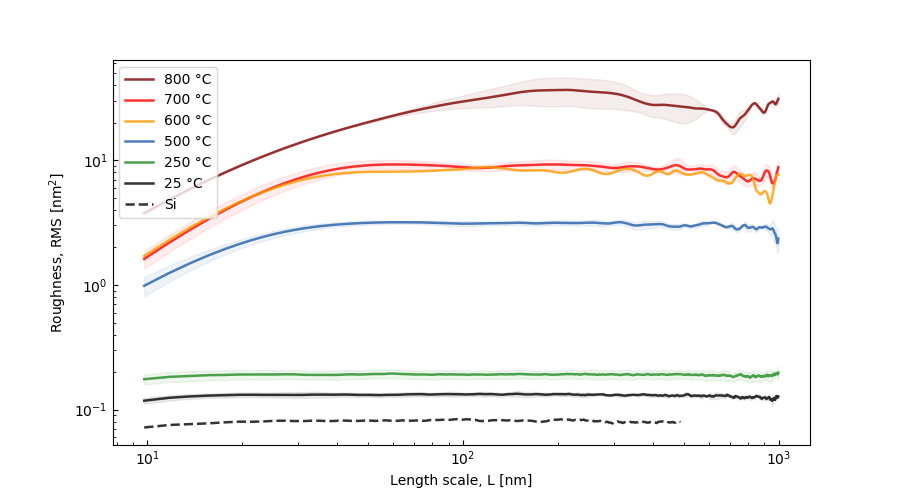

[Text(0.5, 0, 'Length scale, L [nm]')]

In [7]:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['800','700','600','500','250','25']
Si = ['20']
colors = ['#800000','#ff0000','#ff9900', '#225ea8', 'forestgreen','black' ]
col = ['black']
#select certain density:
density = 'H'

for temp, color in zip(temperatures, colors):
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[density][4:1000],
        AvHHcorr[density][temp]['value'][4:1000],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    
    ax.fill_between(
        x_new[density][4:1000],
        AvHHcorr[density][temp]['value_lower'][4:1000],
        AvHHcorr[density][temp]['value_upper'][4:1000],
        color = color,
        alpha = 0.075
    )

    label = None
for temp, color in zip(Si, col):

    label = f"Si"
    ax.loglog(
        x_new[density][4:250],
        AvHHcorr[density][temp]['value'][4:250],
        c = color,
        linestyle = '--',
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    label = None

ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Length scale, L [nm]')
# titl = f"Average HH-correlation function for {density} density Ru"
# fig.suptitle(titl)

# save figure:
# figname = f"AFM_Average HH function - Ru_{density}_withSi.svg"
# fig.savefig(f'AFM_Average HH function - Ru_{density}_withSi.png', dpi=600)
# plt.savefig(fname=figname, dpi =600)

# Fit the data

In [ ]:
temperatures = ['25','250','500','600','700','800']
densities = df.density.unique()

interval = {}
for d in densities:
    interval [d] = {}
    for t in temperatures:
        interval[d][t]={}
        print(d,t)
        interval[d][t]['x0'] = int(input('x0 index:'))
        interval[d][t]['cutoff_idx'] = int(input('cutoff index:'))
print(interval)
interval

with open('Intervals.json', 'w') as f:
    json.dump(interval, f, indent=3)

# Interval: (x0,cutoff)
# H: 1,4  1,4  1,5   1,5   1,5    1,5
# L: 1,4  1,4  1,4   1,4   1,4    1,4 
#LH: 3,7  3,7  3,7   3,7   3,7   7,14

In [8]:
with open('Intervals_v2.json', 'r') as f:
    interval = json.loads(f.read()) 

# new dataframe
temperatures = ['25','250','500','600','700','800']
densities = ['H']

df_results = pd.DataFrame(columns= 
                   ['density',
                    'temp', 
                    'rms',
                    'rms err',
                    'alpha',
                    'alpha err',
                    'corrlen',
                    'xi mean',
                    'xi err'])

Model = lambda x, a, alpha: a*x**(2*alpha)  

fit ={}
for dens in densities:
    fit[dens] = {}   
    for t in temperatures:
        fit[dens][t]={}
        fit[dens][t]['density'] = dens
        fit[dens][t]['temperature'] = t
        fit[dens][t]['limit'] = 2*(AvRMSsq[dens][t]['value'])
        x0 = interval[dens][t]['x0']
        cutoff_idx = interval[dens][t]['cutoff_idx']
        fit[dens][t]['results'], _ = curve_fit(
                                        Model, 
                                        x_new[dens][x0:cutoff_idx], 
                                        AvHHcorr[dens][t]['value'][x0:cutoff_idx], 
                                        sigma = None)
        a =  fit[dens][t]['results'][0]
        alpha  =  fit[dens][t]['results'][1]

        fit[dens][t]['corrlen'] = (1/a*(fit[dens][t]['limit']))**(1/(2*alpha))

# *** Create new dataframe for the calculation of CorrLen and Alpha on this data:
        df_results = df_results.append( 
                {'density': fit[dens][t]['density'],
                 'temp': fit[dens][t]['temperature'],  
                 'rms': AvRMS[dens][t]['value'],
                 'rms err':  AvRMS[dens][t]['err'],
                 'alpha': alpha,
                 'alpha err': AvAlpha[dens][t]['err'],
                 'corrlen': fit[dens][t]['corrlen'],
                 'xi mean': AvCorrLen[dens][t]['value'],
                 'xi err': AvCorrLen[dens][t]['err']
                },
                ignore_index=True)
pickle.dump(df_results, open( "AvHHcorr_interpolated.p", "wb" ) )
df_results.to_excel(f"output_{density}_try.xlsx")  # doctest: +SKIP


/anaconda3/envs/pina/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


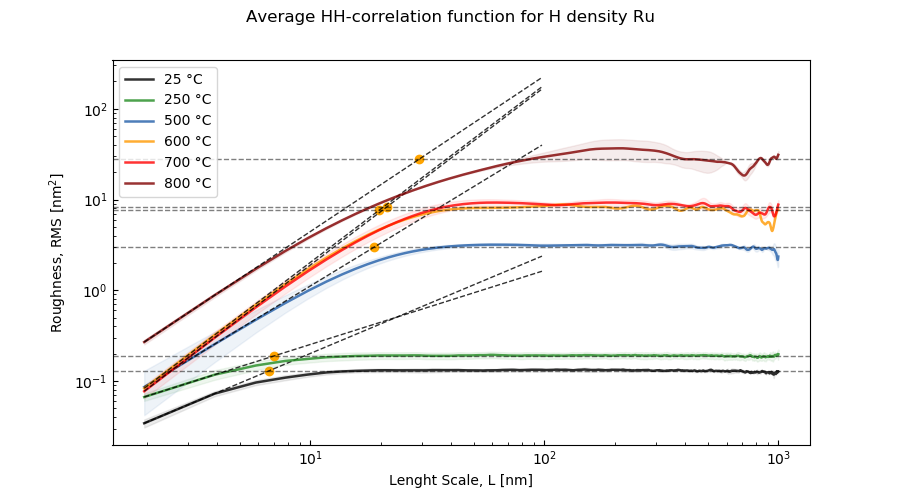

In [10]:
# *** Plot everything in one graph:
plt.style.use('default')
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25', '250','500', '600', '700', '800']
colors = ['black', 'forestgreen','#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    
    density = 'H'
    
    label = f"{temp} °C"
    ax.loglog(
        x_new[density][:],
        AvHHcorr[density][temp]['value'][:],
        c = color,
        alpha = 0.8,
        linewidth = 1.8,
        label = label
    )
    ax.fill_between(
        x_new[density][:],
        AvHHcorr[density][temp]['value_lower'][:],
        AvHHcorr[density][temp]['value_upper'][:],
        color = color,
        alpha = 0.075
    )
    
    ax.loglog(
        x_new[density][interval[dens][temp]['x0']:50], 
        Model(x_new[density][interval[dens][temp]['x0']:50],*fit[density][temp]['results']), 
        linewidth = 1, 
        linestyle='dashed', 
        alpha = 0.8, 
        c ='k')
    ax.scatter(fit[density][temp]['corrlen'], fit[density][temp]['limit'], marker='o', color='orange')
    ax.axhline(fit[density][temp]['limit'], linestyle="dashed",linewidth = 1, color = 'black', zorder =5, alpha =0.5)
    

    label = None
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(which = 'minor', direction = 'in')
ax.set(ylabel='Roughness, RMS [nm$^2$]')
ax.set(xlabel='Lenght Scale, L [nm]')
titl = f"Average HH-correlation function for {density} density Ru"
fig.suptitle(titl)

figname = f"{titl}.png"
# fig.savefig(f'AFM_Average HH function - Ru_{density}.png', dpi=600)

In [ ]:
# *** If I want to see each single HHcorr function (interpolated but not averaged)
fig, ax = plt.subplots(figsize = (9,5))
temperatures = ['25','250','500','600','700','800']
colors = ['black','forestgreen', '#225ea8', '#ff9900', '#ff0000', '#800000']

for temp, color in zip(temperatures, colors):
    selection = df[df.temp==temp]
    selection = selection[selection.density=='LH']
    label = temp
    for idx, row in selection.iterrows():
        ax.loglog(
            x_new[1:],
            row.hhcorr_interp[1:],
            c = color,
            alpha = 0.6,
            linewidth = 1.4,
            label = label
        )
        ax.scatter(x_new[1], row.hhcorr_interp[1], c='darkblue', zorder=10)
        label = None
ax.legend()
titl = f"All HH-correlation functions in one plot - High density Ru"
fig.suptitle(titl)
ax.xaxis.grid() # vertical lines
figname = f"{titl}.png"
fig.savefig(f'Average HH function - Low-High density Ru.png', dpi=600)

